# SyriaTel Customer Churn

![Customer service](images/call_center.png)

## Overview

This project explores and analyses telecom data from SyriaTel to generate insights on how international and voicemail plans, customer service calls and call minutes affect customer satisfaction causing churn. SyriaTel can use this analysis to curb churn and calculate money lost when a customer churns.

## Business Problem

In this project, we address the rate of customer churn at SyriaTel, a telecom company. Customer churn leads to significant revenue loss and increased costs for acquiring new customers. The goal is to identify the key factors that contribute to customer churn, such as international and voicemail plans, customer service interactions, and call usage patterns. By understanding these drivers, SyriaTel can develop targeted strategies to improve customer retention, enhance satisfaction, and reduce the financial impact of churn.

![Telephone](images\telephone-3594206_1280.jpg)

## Objectives

* What is the overall churn rate?
* Which package plans have customers at high risk of leaving?
* What factors contribute to high rate of customer churn?


## Data Understanding

The telecom data used in this project is from `kaggle`[here](https://www.kaggle.com/datasets/becksddf/churn-in-telecoms-dataset).


Import the neccessary libraries

In [66]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
# preprocessing and evaluation metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [68]:
# load dataset

df = pd.read_csv("telecom.csv", sep=",")
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [69]:
# check the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

* The dataset is clean has no missing values
* It has 2 categorical columns (international plan, voicemail plan)

In [70]:
duplicates = df.duplicated()
print(duplicates)

0       False
1       False
2       False
3       False
4       False
        ...  
3328    False
3329    False
3330    False
3331    False
3332    False
Length: 3333, dtype: bool


* The dataset has 3333 entries with no duplicates

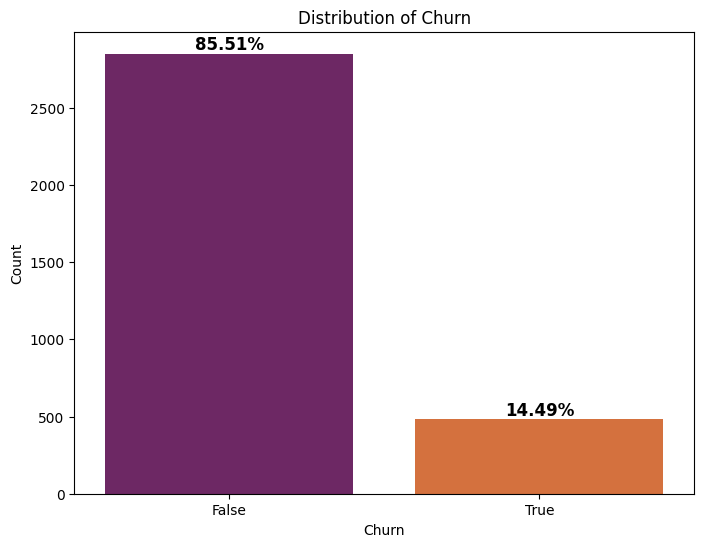

In [71]:
# visualize the distribution of churn and add percentage annotations
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='churn', data=df, palette='inferno')
total = len(df)
for p in ax.patches:
    count = int(p.get_height())
    percentage = 100 * count / total
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')
plt.title('Distribution of Churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

In [72]:
# view churn distribution of values in the dataset
churn_distribution = df['churn'].value_counts()

print(churn_distribution)

churn
False    2850
True      483
Name: count, dtype: int64


In [73]:
# Calculate and display churn percentage
churn_percent = (df['churn'].sum() / len(df)) * 100
print(f"Churn Percentage: {churn_percent:.2f}%")
# check percentage of loyal customers
loyal_customers = (churn_distribution[False] / churn_distribution.sum()) * 100

print(f"Loyal Percentage: {loyal_customers:.2f}%")

Churn Percentage: 14.49%
Loyal Percentage: 85.51%


* There are 85.51 % of loyal customers and 14.49% churn rate
* The dataset has more records in one class therefore it is unbalanced.

In [74]:
# drop phone number 
df = df.drop(columns=['phone number'],axis=1)

Map binary features international plan and voicemail plan
yes = 1, 
no = 0

In [75]:
# map international and voicemail plans to 1 and 0
df[['international plan', 'voice mail plan']] = df[['international plan', 'voice mail plan']].replace(['yes', 'no'], ['1', '0']).astype(int)

### Multivariate Analysis

This is to check the relationship of features

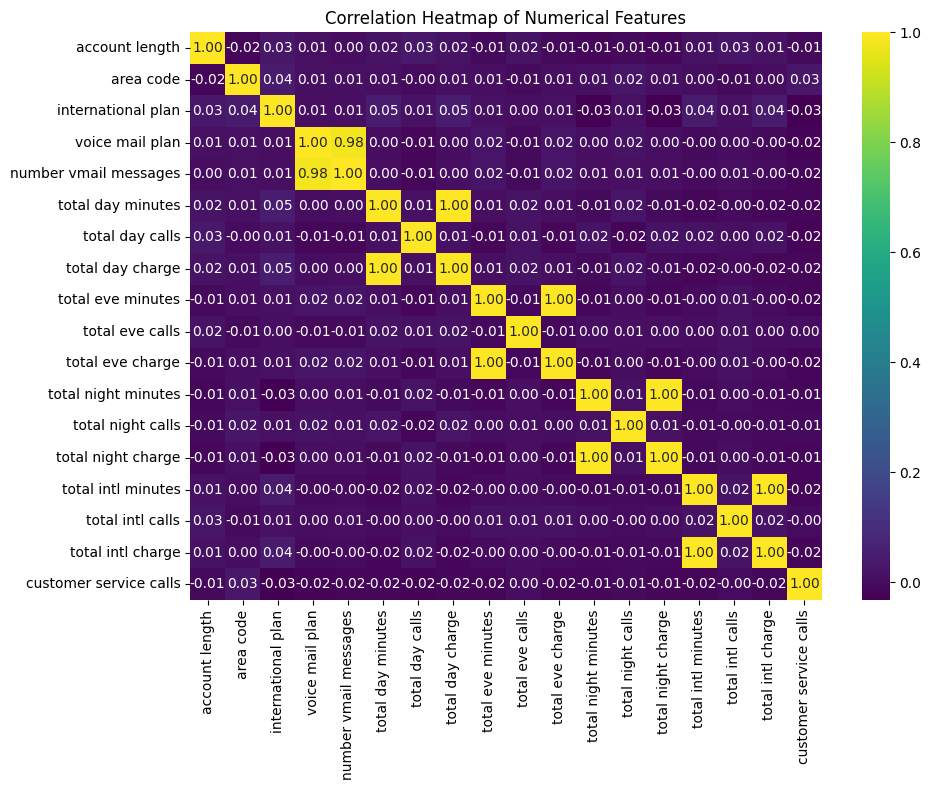

In [76]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_df.corr(method='spearman')
#mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='viridis')
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

*Interpretation*

`Redundacy`
* The heatmap shows perfect correlations between minutes and charge for day, evening and night which indicates multicollinearity


In [77]:
# drop columns to avoid redundancy
df = df.drop(columns=['total day charge', 'total eve charge', 'total night charge', 'total intl charge'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   international plan      3333 non-null   int64  
 4   voice mail plan         3333 non-null   int64  
 5   number vmail messages   3333 non-null   int64  
 6   total day minutes       3333 non-null   float64
 7   total day calls         3333 non-null   int64  
 8   total eve minutes       3333 non-null   float64
 9   total eve calls         3333 non-null   int64  
 10  total night minutes     3333 non-null   float64
 11  total night calls       3333 non-null   int64  
 12  total intl minutes      3333 non-null   float64
 13  total intl calls        3333 non-null   int64  
 14  customer service calls  3333 non-null   

In [78]:
# Calls and minutes aggregate
df['total calls'] = df['total day calls'] + df['total eve calls'] + df['total night calls'] + df['total intl calls'] + df['customer service calls']
df['total minutes'] = df['total day minutes'] + df['total eve minutes'] + df['total night minutes'] + df['total intl minutes']

print(df['total calls'].describe(), df['total minutes'].describe(), sep='\n\n')

count    3333.00000
mean      306.69997
std        34.44939
min       194.00000
25%       284.00000
50%       307.00000
75%       330.00000
max       418.00000
Name: total calls, dtype: float64

count    3333.000000
mean      591.864776
std        89.954251
min       284.300000
25%       531.500000
50%       593.600000
75%       652.400000
max       885.000000
Name: total minutes, dtype: float64


Check average calls and minutes by state

In [79]:
# total calls and total minutes per state
calls_by_state = df.groupby('state')['total calls'].sum().sort_values(ascending=False)
minutes_by_state = df.groupby('state')['total minutes'].sum().sort_values(ascending=False)

avg_minutes_by_state = df.groupby('state')['total minutes'].mean().sort_values(ascending=False)
avg_calls_by_state = df.groupby('state')['total calls'].mean().sort_values(ascending=False)
records_by_state = df.groupby('state')['churn'].count().sort_values(ascending=False)

print("Top 5 states on average total minutes:\n", avg_minutes_by_state.head())

print("Top 5 states on average total calls:\n",avg_calls_by_state.head())
      
print("Top 5 states on average total records:\n",records_by_state.head())


Top 5 states on average total minutes:
 state
IN    619.323944
NJ    611.707353
KS    608.884286
MA    608.644615
TN    606.994340
Name: total minutes, dtype: float64
Top 5 states on average total calls:
 state
GA    318.351852
FL    315.809524
ND    314.258065
ID    312.931507
NC    312.911765
Name: total calls, dtype: float64
Top 5 states on average total records:
 state
WV    106
MN     84
NY     83
AL     80
OH     78
Name: churn, dtype: int64


* From the top 5 states, indiana(IN) has the highest average total minutes
* Georgia(GA) has the highest average total calls
* West Virginia (WV) has the highest number of churn customers


In [80]:
most_calls = calls_by_state.idxmax()
least_calls = calls_by_state.idxmin()
print('Most calls:', most_calls)
print('Least calls:', least_calls)

most_minutes = minutes_by_state.idxmax()
least_minutes = minutes_by_state.idxmin()
print('Most minutes:', most_minutes)
print('Least minutes:', least_minutes)

Most calls: WV
Least calls: CA
Most minutes: WV
Least minutes: CA


*Interpretation*
* West Virginia has the highest number of calls and minutes
* California has the least calls and least minutes

*Insights*
* High number of calls and more minutes might cause the high number of churn.

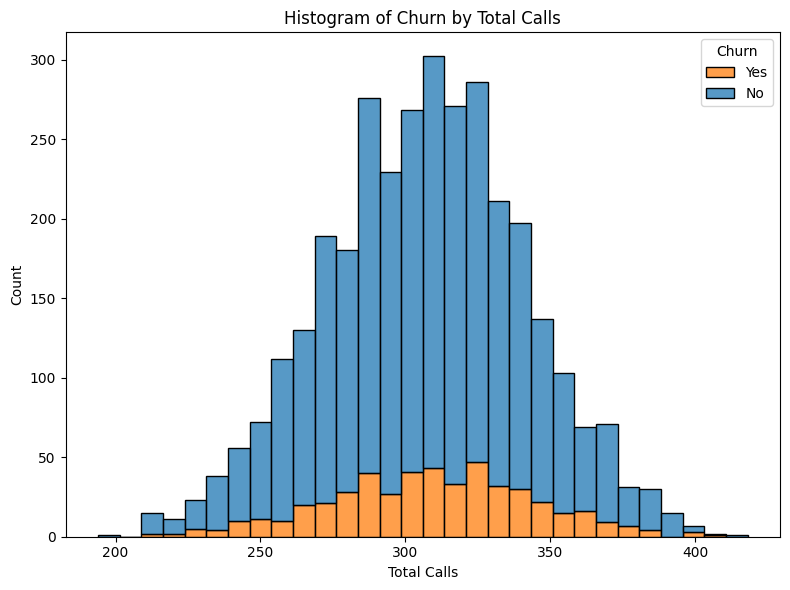

In [81]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='total calls', hue='churn', bins=30, kde=False, multiple='stack')
plt.title('Histogram of Churn by Total Calls')
plt.xlabel('Total Calls')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['Yes', 'No'])
plt.tight_layout()
plt.show()


*Insights*
* Customers with very low number of calls are more likely to churn

### Bivariate Analysis

### Churn rate by voice mail plan and international plan

In [82]:
# print churn rate by voice mail plan and international plan
print(df.groupby(['voice mail plan', 'international plan'])['churn'].mean())#end='\n\n')


voice mail plan  international plan
0                0                     0.138532
                 1                     0.437229
1                0                     0.053012
                 1                     0.391304
Name: churn, dtype: float64


Visualization

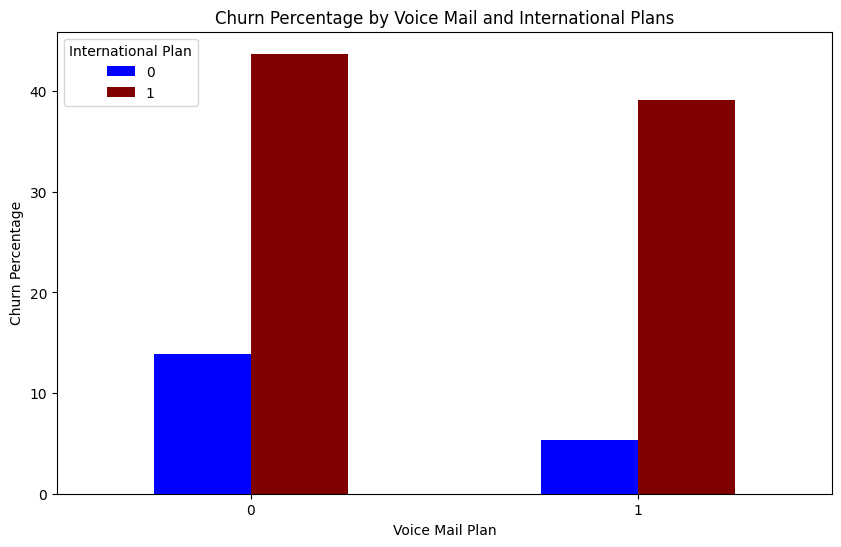

In [83]:
# Calculate churn percentage
churn_percentage = df.groupby(['voice mail plan', 'international plan'])['churn'].mean() * 100

# Plot the churn percentage
churn_percentage.unstack().plot(kind='bar', figsize=(10, 6), color=['blue', 'maroon'])
plt.title('Churn Percentage by Voice Mail and International Plans')
plt.xlabel('Voice Mail Plan')
plt.ylabel('Churn Percentage')
plt.xticks(rotation=0)
plt.legend(title='International Plan')
plt.show()

*Interpretation*
* Customers without an international plan (blue bars )but have voice mail plan (yes)have low churn percentage
* For customers with an international plan, presence of voice mail plan small impact on churn.


*Insights*
* International plan seems to strongly cause churn.
* For customers without an international plan, offering them voice mail plan may retain them.

A similar visualization on different axes

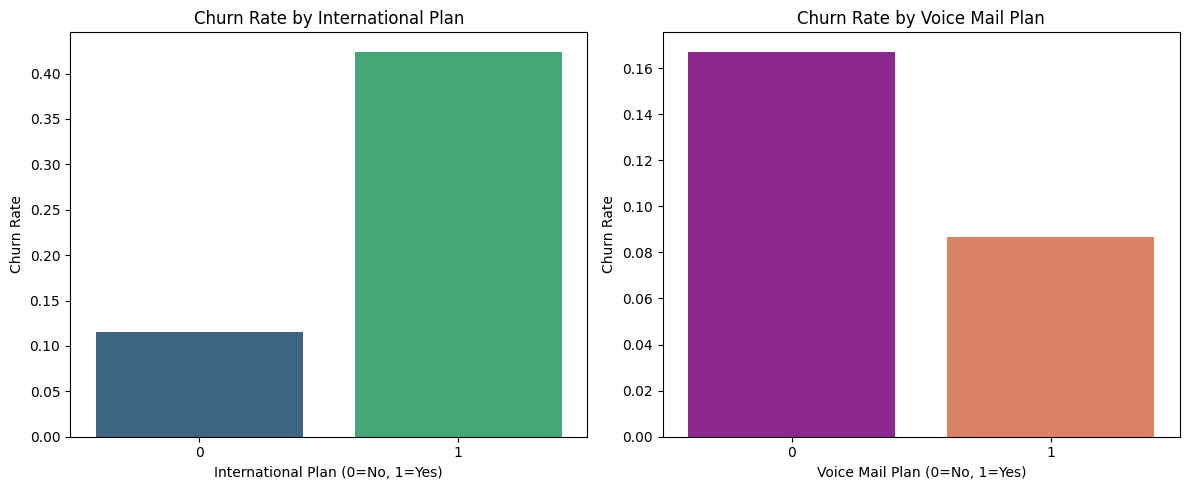

In [84]:
# Visualize the effect of international plan and voice mail plan on customer satisfaction (churn)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# International plan vs churn
sns.barplot(x='international plan', y='churn', data=df, ax=axes[0], errorbar=None, palette='viridis')
axes[0].set_title('Churn Rate by International Plan')
axes[0].set_xlabel('International Plan (0=No, 1=Yes)')
axes[0].set_ylabel('Churn Rate')

# Voice mail plan vs churn
sns.barplot(x='voice mail plan', y='churn', data=df, ax=axes[1], errorbar=None, palette='plasma')
axes[1].set_title('Churn Rate by Voice Mail Plan')
axes[1].set_xlabel('Voice Mail Plan (0=No, 1=Yes)')
axes[1].set_ylabel('Churn Rate')

plt.tight_layout()
plt.show()

### Churn by Customer service calls

In [85]:
# check churn by customer service calls
df.groupby('churn')['customer service calls'].describe()

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
False,2850.0,1.449825,1.163883,0.0,1.0,1.0,2.0,8.0
True,483.0,2.229814,1.853275,0.0,1.0,2.0,4.0,9.0


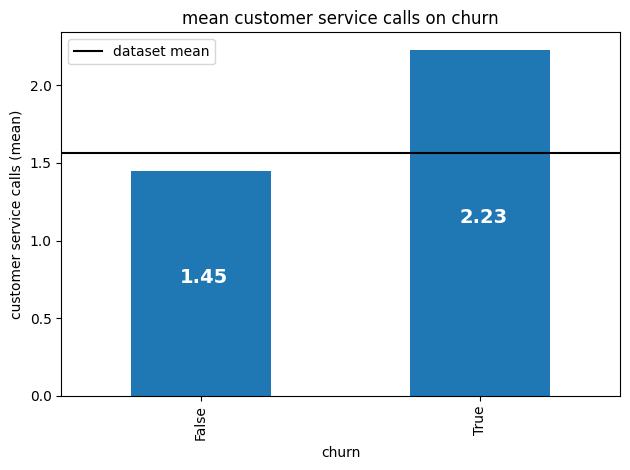

In [86]:
# Visualize customer service churn
fig, ax = plt.subplots()
avg_calls = df.groupby('churn')['customer service calls'].mean()
avg_calls.plot(kind='bar', ax=ax, label='')
ax.axhline(y=df['customer service calls'].mean(),c='black', label='dataset mean')
ax.legend()
ax.set_title('mean customer service calls on churn')
ax.set_ylabel('customer service calls (mean)', rotation = 90)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    ax.annotate('{:.2f}'.format(height), (p.get_x()+.35*width, p.get_y()+.5*height), color = 'white', weight = 'bold', size = 14)

plt.tight_layout()
plt.show()

*Interpretation*
* Disloyal customers made more calls than loyal customers
* Average number of calls made by disloyal customers is higher (2.23) than the dataset mean approximately (1.6)

*Insights*
* Dissatisfied customers may tend to make more calls to customer service and eventually churn

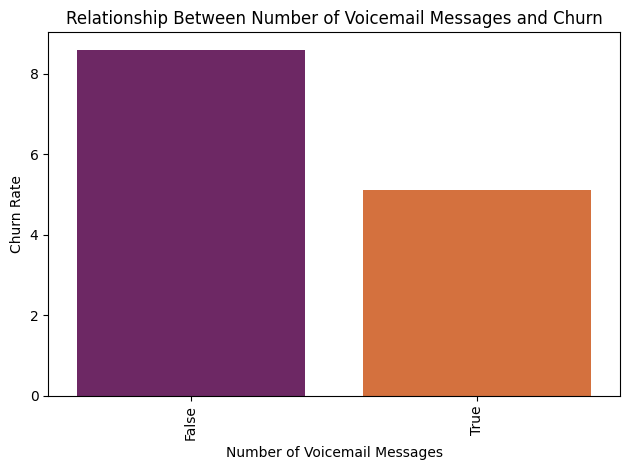

In [87]:
sns.barplot(y='number vmail messages', x='churn', data=df, errorbar=None, palette='inferno')
plt.title('Relationship Between Number of Voicemail Messages and Churn')
plt.xlabel('Number of Voicemail Messages')
plt.ylabel('Churn Rate')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

*Interpretation*
* Loyal customers(not churned) have high number of voice messages compared to disloyal(churned)
* Disloyal custumers have lower voicemail messages

*Insights*
* Customers actively using voicemail messages are engaged probably satisfied with the service and less likely to churn
* Customers less engaged are likely dissatisfied with the service raising the probability to churn 

## Data Preparation

### Preprocessing

In [88]:
# define categorical columns
categorical_columns = df[df.select_dtypes(exclude=['number']).columns]

# view categorical columns
categorical_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   state   3333 non-null   object
 1   churn   3333 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 29.4+ KB


Use One-hot Encoding to get dummies

In [89]:
# use one hot encoding on state and convert to integer
state_dummy = pd.get_dummies(df, columns=["state", 'area code'],drop_first=True)

state_dummy = state_dummy.astype(int)
state_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 68 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   account length          3333 non-null   int64
 1   international plan      3333 non-null   int64
 2   voice mail plan         3333 non-null   int64
 3   number vmail messages   3333 non-null   int64
 4   total day minutes       3333 non-null   int64
 5   total day calls         3333 non-null   int64
 6   total eve minutes       3333 non-null   int64
 7   total eve calls         3333 non-null   int64
 8   total night minutes     3333 non-null   int64
 9   total night calls       3333 non-null   int64
 10  total intl minutes      3333 non-null   int64
 11  total intl calls        3333 non-null   int64
 12  customer service calls  3333 non-null   int64
 13  churn                   3333 non-null   int64
 14  total calls             3333 non-null   int64
 15  total minutes        

Scale the data to unit variance

In [90]:
#using standard scaler to make values same unit
numeric_features = df.select_dtypes(include=['number'])

# instantiate standard scaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features)
scaled_features_df = pd.DataFrame(scaled_features, columns=numeric_features.columns)
print(scaled_features_df.head())

   account length  area code  international plan  voice mail plan  \
0        0.676489  -0.523603           -0.327580         1.617086   
1        0.149065  -0.523603           -0.327580         1.617086   
2        0.902529  -0.523603           -0.327580        -0.618396   
3       -0.428590  -0.688834            3.052685        -0.618396   
4       -0.654629  -0.523603            3.052685        -0.618396   

   number vmail messages  total day minutes  total day calls  \
0               1.234883           1.566767         0.476643   
1               1.307948          -0.333738         1.124503   
2              -0.591760           1.168304         0.675985   
3              -0.591760           2.196596        -1.466936   
4              -0.591760          -0.240090         0.626149   

   total eve minutes  total eve calls  total night minutes  total night calls  \
0          -0.070610        -0.055940             0.866743          -0.465494   
1          -0.108080         0.144867 

Combine the datasets

In [91]:
# combine state dummies with scaled features df
df_combined = pd.concat([state_dummy, scaled_features_df], axis=1)
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 84 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          3333 non-null   int64  
 1   international plan      3333 non-null   int64  
 2   voice mail plan         3333 non-null   int64  
 3   number vmail messages   3333 non-null   int64  
 4   total day minutes       3333 non-null   int64  
 5   total day calls         3333 non-null   int64  
 6   total eve minutes       3333 non-null   int64  
 7   total eve calls         3333 non-null   int64  
 8   total night minutes     3333 non-null   int64  
 9   total night calls       3333 non-null   int64  
 10  total intl minutes      3333 non-null   int64  
 11  total intl calls        3333 non-null   int64  
 12  customer service calls  3333 non-null   int64  
 13  churn                   3333 non-null   int64  
 14  total calls             3333 non-null   

### Split the data into training and testing

In [92]:
# name the predictor and the target variables
X = df_combined.drop(columns=['churn'], axis=1)
y = df['churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
target_names = ['False.', 'True']

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (2666, 83)
Testing set size: (667, 83)


Use Logistic Regression to create base model

In [93]:
# use Logistic regression
lr = LogisticRegression(max_iter=6000)

# fit and train the model
lr.fit(X_train, y_train)

#prediction
y_pred_1 = lr.predict(X_test)

In [94]:
# print the report
print(classification_report(y_test, y_pred_1, target_names=target_names))

              precision    recall  f1-score   support

      False.       0.87      0.97      0.92       566
        True       0.54      0.19      0.28       101

    accuracy                           0.85       667
   macro avg       0.71      0.58      0.60       667
weighted avg       0.82      0.85      0.82       667



In [95]:
# Evaluate the model perfomance
acc_lr = accuracy_score(y_test, y_pred_1)
f1_lr = f1_score(y_test, y_pred_1)
recall_lr = recall_score(y_test, y_pred_1)
precision_lr = precision_score(y_test, y_pred_1)

print(f"F1 score: {f1_lr}, \n Recall: {recall_lr}, \n Precision: {precision_lr}, \n Accuracy: {acc_lr}")


F1 score: 0.27941176470588236, 
 Recall: 0.18811881188118812, 
 Precision: 0.5428571428571428, 
 Accuracy: 0.8530734632683659


*Interpretation*

* Precision - The model correctly predicts that 54% of the instances a customer churned
* Recall - The model is fails to correctly predict customers who churned.
* Accuracy - The model's accuracy is 85%, meaning it can be improved by balancing classes

* Class imbalance - support of 'False' 566 and 'True' 101

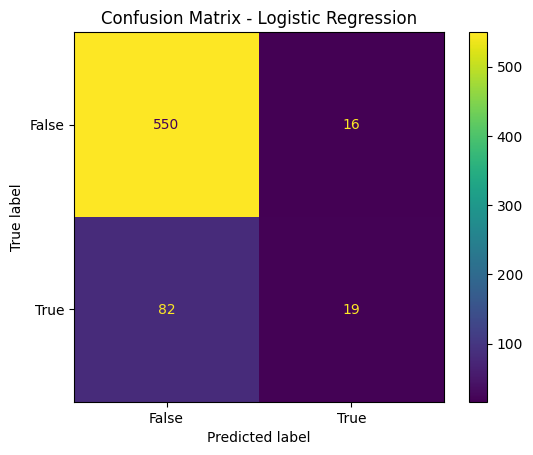

In [96]:
# Create a confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_1)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()



* The model is biased towards predicting the majority class and fails to effectively predict the minority class

### Apply SMOTE to solve class imbalance

In [97]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

churn
False    2850
True      483
Name: count, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

churn
False    2284
True     2284
Name: count, dtype: int64


The data is balanced

In [98]:
# use the balanced data
logreg = LogisticRegression(max_iter=6000, C=1e12, fit_intercept=False, solver='liblinear')
logreg.fit(X_train_resampled, y_train_resampled)

LogisticRegression(C=1000000000000.0, fit_intercept=False, max_iter=6000,
                   solver='liblinear')

In [99]:
# check the metrics
# calculate the probability scores of each of the datapoints:
y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

In [100]:
# print the Auc
print('AUC: {}'.format(auc(fpr,tpr)))

AUC: 0.8172165273064409


Plot the ROC curve

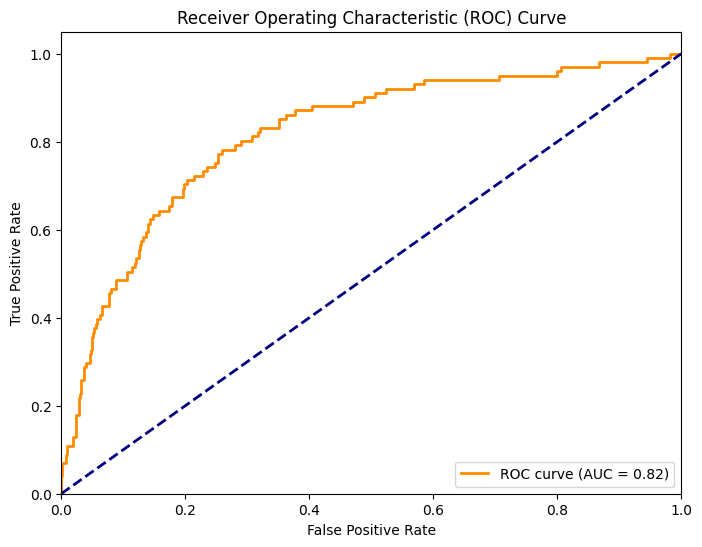

In [101]:

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The model's Auc score of 0.82 shows 82% chance of being able to distinguish between a positive and a negative instance.

### Classification using Decision Trees 

In [102]:
# instantiate the model
tree = DecisionTreeClassifier(random_state=24)

# fit the model on resampled / balanced data
tree.fit(X_train_resampled, y_train_resampled)

# predict
y_pred_tree = tree.predict( X_test)

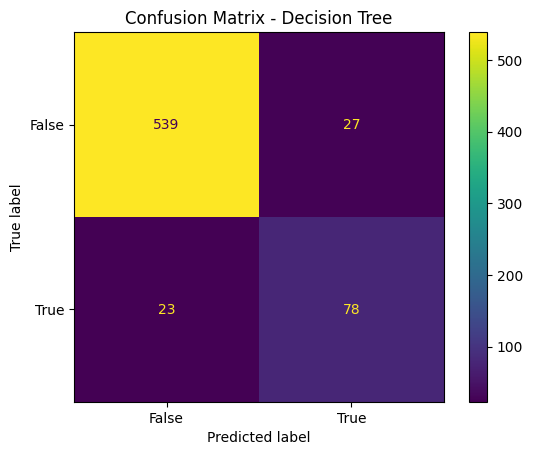

In [103]:
# Plot confusion matrix for Decision Tree on resampled data

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tree)
plt.title("Confusion Matrix - Decision Tree")
plt.show()


In [104]:
# evaluate the model
f1_tree = f1_score(y_test, y_pred_tree)
recall_tree = recall_score(y_test, y_pred_tree)
precision_tree = precision_score(y_test, y_pred_tree)
acc_tree = accuracy_score(y_test, y_pred_tree)

print(f"F1 score: {f1_tree}, \n Recall: {recall_tree}, \n Precision: {precision_tree}, \n Accuracy: {acc_tree}")

F1 score: 0.7572815533980582, 
 Recall: 0.7722772277227723, 
 Precision: 0.7428571428571429, 
 Accuracy: 0.9250374812593704


*Interpretation* 
 * The decision tree performed better than the logistic model
 * The f1_score of 77% is good metric 
 * The overall metrics are good, with an accuracy of 92% and the model is not yet tuned
 

### Hyperparameter Tuning

In [105]:
# Tuning the moddel using GridsearchCV

"""
max_depth - length of tree

min_samples_split - number of samples to split an internal node

criterion - entropy , gini

max_features - number of predictors to use during each split, higher may lead to overfitting, lower generalizes

splitter - best , random - the strategy used choose split

min_samples_leaf - how many you need in a group/leaf mode

"""
tree_1= DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_depth': [None, 3, 5, 20],
    'min_samples_split': [5, 20,100, 1000],
    'min_samples_leaf': [5, 10, 15],
    'criterion':['gini', 'entropy'] ,
    'max_features': ['sqrt','log2']
    }

# instantiate
grid_search = GridSearchCV(estimator=tree_1, param_grid=param_grid, cv=2, scoring = 'accuracy' )

#training/fitting the  gridsearch
grid_search.fit(X_train_resampled, y_train_resampled)


GridSearchCV(cv=2, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 5, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [5, 20, 100, 1000]},
             scoring='accuracy')

In [106]:
# check the parameters 
params = grid_search.best_params_
score = grid_search.best_score_

print(f'Best Parameters: {params}')
print(f'Best Scores: {score:.2f}')

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20}
Best Scores: 0.89


In [107]:
# Apply the tuning to a grid model
grid_model = grid_search.best_estimator_

#predicting using the best grid search model
y_preds_g = grid_model.predict(X_test)


f1_g = f1_score(y_test, y_preds_g)
acc_g = accuracy_score(y_test, y_preds_g)
precision_g = precision_score(y_test, y_preds_g)
recall_g = recall_score(y_test, y_preds_g)

print(
    f"Grid model has an: \n Accuracy: {acc_g:.2f}, \n Precision: {precision_g:.2f}, \n Recall: {recall_g:.2f}, \n F1 Score: {f1_g:.2f}"
)


Grid model has an: 
 Accuracy: 0.90, 
 Precision: 0.65, 
 Recall: 0.73, 
 F1 Score: 0.69


In [108]:
# compare the two models performance
print("Decision Tree (tree) Results:")
print(classification_report(y_test, y_pred_tree))

print("\nTuned Decision Tree (grid_model) Results:")
print(classification_report(y_test, y_preds_g))

Decision Tree (tree) Results:
              precision    recall  f1-score   support

       False       0.96      0.95      0.96       566
        True       0.74      0.77      0.76       101

    accuracy                           0.93       667
   macro avg       0.85      0.86      0.86       667
weighted avg       0.93      0.93      0.93       667


Tuned Decision Tree (grid_model) Results:
              precision    recall  f1-score   support

       False       0.95      0.93      0.94       566
        True       0.65      0.73      0.69       101

    accuracy                           0.90       667
   macro avg       0.80      0.83      0.81       667
weighted avg       0.91      0.90      0.90       667



*Interpretation*
* The original Decision tree performed better than the tuned Decision tree
* Hyperparameter tuning did not improve minority class performance

In [109]:
# Count number of customers predicted to churn (True) by each model
n_churned_lr = np.sum(y_pred_1)
n_churned_tree = np.sum(y_pred_tree)

print(f"Logistic Regression predicted {n_churned_lr} customers to churn.")
print(f"Decision Tree predicted {n_churned_tree} customers to churn.")

Logistic Regression predicted 35 customers to churn.
Decision Tree predicted 105 customers to churn.


## Analyze factors causing churn

In [110]:
# Analyze feature importances from the decision tree to identify key factors causing churn
importances = tree.feature_importances_
feature_names = X_train.columns

# Get top features
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("Top factors causing churn based on Decision Tree importance:")
print(feature_importance_df.head(10))

Top factors causing churn based on Decision Tree importance:
                   feature  importance
69      international plan    0.179466
82           total minutes    0.167942
80  customer service calls    0.164763
72       total day minutes    0.119162
68               area code    0.078781
78      total intl minutes    0.038379
70         voice mail plan    0.038101
1       international plan    0.026431
11        total intl calls    0.019004
74       total eve minutes    0.018283


### Features that contribute to churn

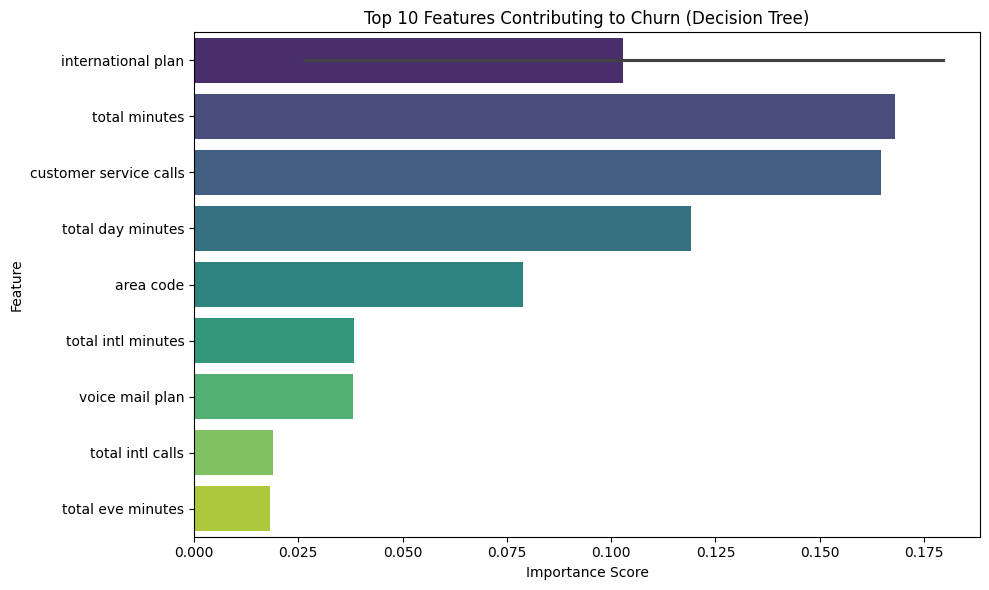

In [111]:
# Visualize top 10 features contributing to churn from the decision tree
plt.figure(figsize=(10, 6))
sns.barplot(
    x='importance',
    y='feature',
    data=feature_importance_df.head(10),
    palette='viridis'
)
plt.title('Top 10 Features Contributing to Churn (Decision Tree)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Conclusion
### The analysis of the SyriaTel customer churn dataset reveals several key insights into the drivers of customer churn.

* High number of customer service calls show dissatisfaction and a potential churn.
* Customers with an international plan are more likely to churn, and those who make more customer service calls also show a higher tendency to leave, indicating dissatisfaction with the service.
* Customers who actively use voicemail services tend to be more loyal. 
* The models show that accuracy is high due to class imbalance, recall for the minority (churn) class is improved after applying SMOTE. 
* Feature importance analysis confirms that customer service calls, international plan, and usage patterns are significant predictors of churn.

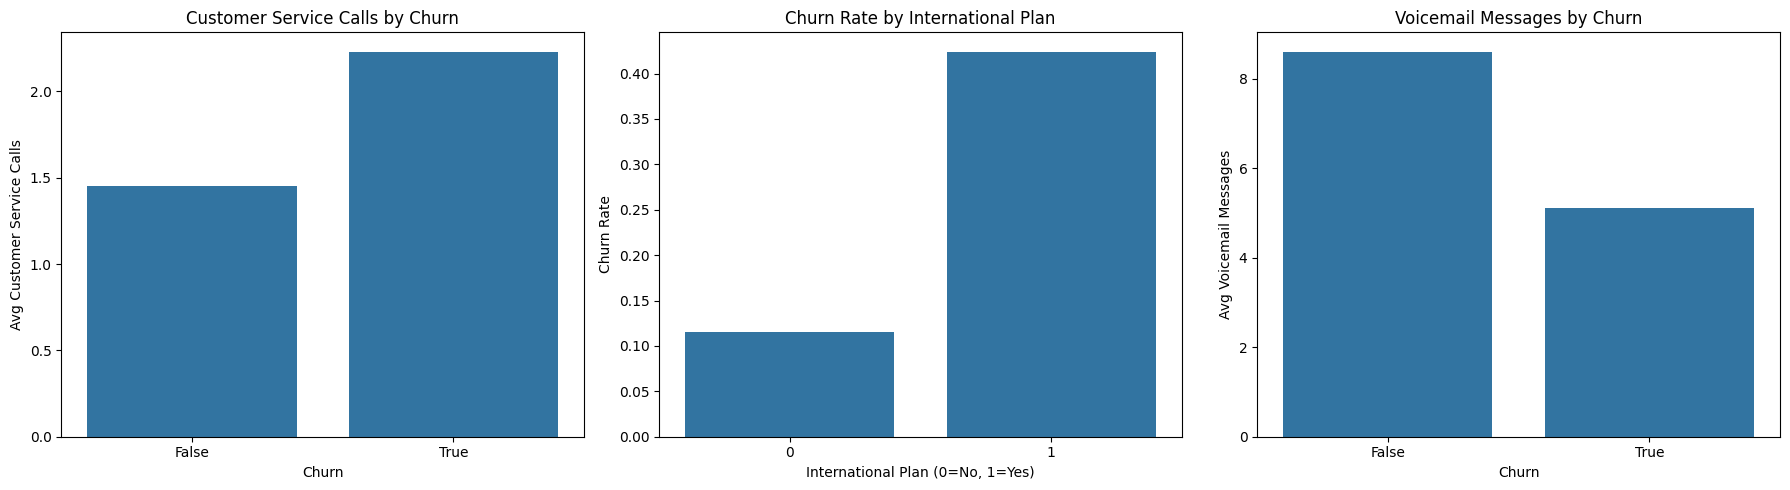

In [112]:
# Visualize the conclusion

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Customer service calls vs churn
sns.barplot(x='churn', y='customer service calls', data=df, ax=axes[0], errorbar=None)
axes[0].set_title('Customer Service Calls by Churn')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Avg Customer Service Calls')

# 2. International plan vs churn
sns.barplot(x='international plan', y='churn', data=df, ax=axes[1], errorbar=None)
axes[1].set_title('Churn Rate by International Plan')
axes[1].set_xlabel('International Plan (0=No, 1=Yes)')
axes[1].set_ylabel('Churn Rate')

# 3. Voicemail usage vs churn
sns.barplot(x='churn', y='number vmail messages', data=df, 
ax=axes[2], errorbar=None)
axes[2].set_title('Voicemail Messages by Churn')
axes[2].set_xlabel('Churn')
axes[2].set_ylabel('Avg Voicemail Messages')

plt.tight_layout()
plt.show()



## Recommendations
- Offering incentives or tailored packages to these segments, as well as promoting voicemail plan usage, may help increase satisfaction and retention.
- SyriaTel should focus on improving customer service quality especially customers who call for support or help, this would reduce churn and loss of revenue
- There should be a special consideration to customers with international plans as they have a high chance of leaving.